# Video processing - lane detection 

In [1]:
from __future__ import print_function

%matplotlib inline
import cv2
import imageio
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual

from matplotlib import pyplot as plt

import numpy.matlib
import numpy as np
import os

from scipy import ndimage
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.filters import gaussian
import skvideo.io
from skimage.transform import hough_line, hough_line_peaks

import time

#import skvideo
#skvideo.setFFmpegPath(r"C:\Users\mv170185d\Anaconda3\Lib\site-packages\skvideo\io")
#pip install ffmpeg scikit-video

In [2]:
def segment_lanes(image):
    """
    Input:
        - RGB image, pixel intensity is in the range 0-255
    Output:
        - grayscale segmented input image in the range 0-1 which separates the region of interest - left and right band,
          because the ultimate goal is to highlight the mentioned bands, so by suppressing the other parts of the image, we make it easier
          we speed up the process.
    """
    # Ulazna slika se predstavlja u HLS kolor distemu jer intuitivno predstavlja boje, te je pogodan za 
    # izdvajanje bele i žute. Dobićemo masku koja je takođe pogodna za isecanje regiona od interesa.
    converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # maska koja izdvaja belu boju
    lower_threshold = np.uint8([0, 235, 0])
    upper_threshold = np.uint8([180, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    """"
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title('bela maska')
    plt.imshow(white_mask, vmin = 0, vmax = 255, cmap = 'gray')
    plt.show()
    """
    # maska koja izdvaja zutu boju
    lower_threshold = np.uint8([20, 100, 90]) 
    upper_threshold = np.uint8([25, 225, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    """"
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title('zuta maska')
    plt.imshow(yellow_mask, vmin = 0, vmax = 255, cmap = 'gray')
    plt.show()
    """
    # Sečenje slike prema levoj žutoj traci. Ovo je bilo potrebno uraditi kako bi se uklonili objekti koji su takođe 
    # bele boje, a ne predstavljaju kolovozne trake.
    [M,N] = np.shape(image[:,:,0])
    mask_crop = np.zeros(shape = np.shape(yellow_mask), dtype = 'uint8')
    start_found = False; #oznacava da je nadjen pocetak zute trake gledano odozdole - blize haubi
    start = M;
    stop = 0;
    yellow_lane_len = 0;

    for i in range(M-1,-1,-1):
        if((start_found == False) and (max(yellow_mask[i,:].flatten()) > 0)):
            # Odozdole nećemo odmah naići na žutu liniju, nekad je u kadru hauba, pa start označava koordinatu x ose
            # kada je pronđen prvi žuti piksel.
            start = i
            start_found = True
        if(start_found == True):
            # kada odozdole naiđemo na žutu liniju treba startovati brojač projekcije žute linije na x osu da se
            # slika ne bi prerano odsekla kada odmah naiđe prekid da žutoj liniji (recimo senka drveća na putu)
            yellow_lane_len = yellow_lane_len + 1;
        if((start_found == True) and (sum(yellow_mask[i,:].flatten()) < 5*255) and (yellow_lane_len > 250)):
           # Stop se određuje kao x koordinana gde iščezava žuta linija (ima manje od 5 piksela). Za svaki slučaj se 
           # dodaje 5 redova kao doadatna sigurnost (da se ne bi uhvatila neka bela zgrada koja je bila bliska granici
           # označenoj sa stop)
            stop = i + 5;
            break;
    
    mask_crop[stop:start,:] = 255; # ima horizontalnu debelu straftu
    #mask_yellow_crop = cv2.bitwise_and(mask_crop, yellow_mask)
    #mask_white_crop = cv2.bitwise_and(mask_crop, white_mask)
    
    # Sečenje slike sleva jer se desi da prodje beli automobil u suprotnom smeru (levo od žute trake) 
    mask_yellow_crop = yellow_mask.copy()
    mask_white_crop = white_mask.copy()
    
    mask_yellow_crop[0:stop,:] = 0
    mask_white_crop[0:stop,:] = 0
    
    yellow_found = False; #oznacava da je nađen pocetak žute trake gledano sleva
    stop_left = 0;
    for i in range(0,N):
        if((yellow_found == False) and (max(mask_yellow_crop[:,i].flatten()) > 0)):
            stop_left = i
            yellow_found = True
            break
    
    mask_white_crop[:,0:stop_left] = 0;
    # Ukoliko je posle svih odsecanja nije ostalo dovoljno belih piksela za detekciju desne trake koristi se stara 
    # zapamćena maska.
    if (sum(mask_white_crop.flatten())<3*255):
        mask_white_crop = mask_white
    
    # Spajanje bele i žute maske
    mask = cv2.bitwise_or(mask_white_crop, mask_yellow_crop)
    
    return (img_as_float(mask),img_as_float(mask_white_crop),img_as_float(mask_yellow_crop), img_as_float(yellow_mask))

### Plotting segmentation results

In [3]:
image_1 = imageio.imread('.\sekvence\\test1.jpg')
image_2 = imageio.imread('.\sekvence\\test2.jpg')
image_3 = imageio.imread('.\sekvence\\test3.jpg')
image_4 = imageio.imread('.\sekvence\\test4.jpg')
image_5 = imageio.imread('.\sekvence\\test5.jpg')
image_6 = imageio.imread('.\sekvence\\test6.jpg')

In [4]:
segm_image_1,_,_,_ = segment_lanes(image_1)
segm_image_2,_,yellow_mask_crop,yellow_mask = segment_lanes(image_2)
segm_image_3,_,_,_ = segment_lanes(image_3)
segm_image_4,_,_,_ = segment_lanes(image_4)
segm_image_5,_,_,_ = segment_lanes(image_5)
segm_image_6,_,_,_ = segment_lanes(image_6)

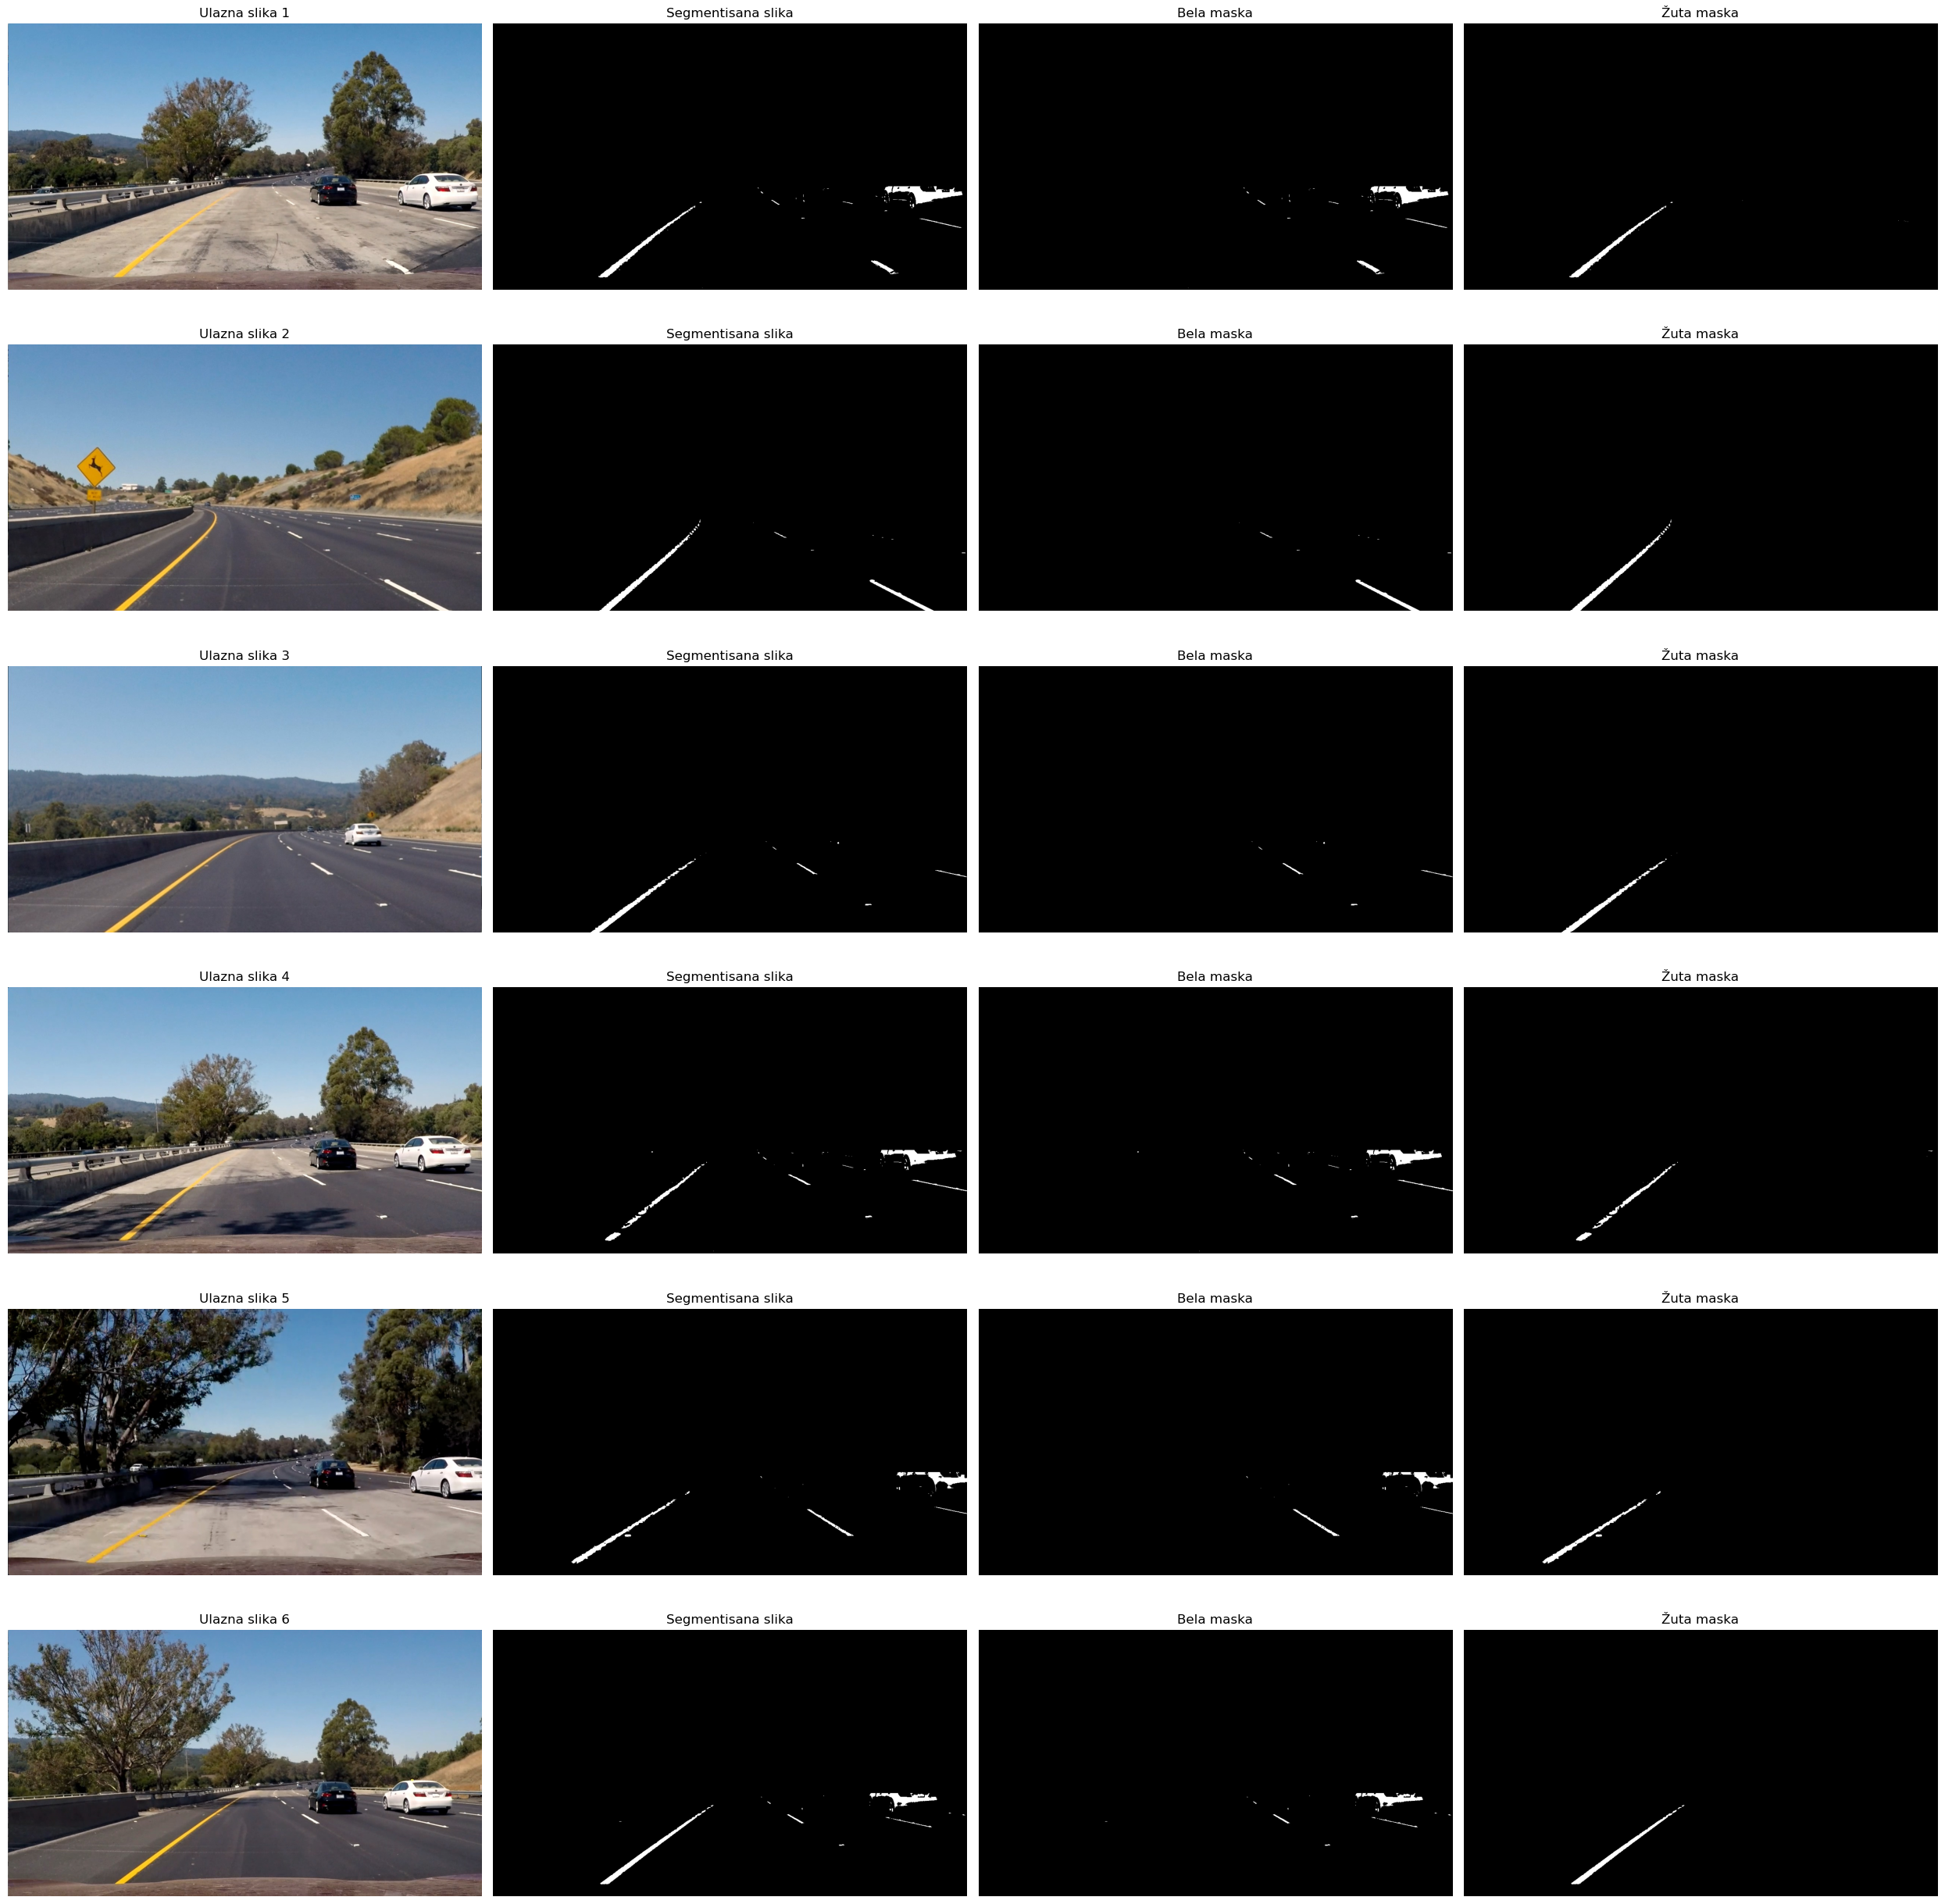

In [5]:
fig, axes = plt.subplots(nrows = 6, ncols = 4, figsize=(25,25), dpi=100)

for i in range(6):
    name = 'test' + str(i+1)
    image = imageio.imread(".\sekvence\\" + name + '.jpg')
    segm_image,segm_white,segm_yellow,_ = segment_lanes(image)
        
    axes[i,0].imshow(image, vmin = 0, vmax = 255, cmap='jet'); axes[i,0].set_axis_off();
    axes[i,0].set_title(label = 'Ulazna slika '+ str(i+1));
    axes[i,1].imshow(segm_image, vmin=0, vmax=1, cmap='gray'); axes[i,1].set_axis_off();
    axes[i,1].set_title('Segmentisana slika');
    axes[i,2].imshow(segm_white, vmin=0, vmax=1, cmap='gray'); axes[i,2].set_axis_off();
    axes[i,2].set_title('Bela maska');
    axes[i,3].imshow(segm_yellow, vmin=0, vmax=1, cmap='gray'); axes[i,3].set_axis_off();
    axes[i,3].set_title('Žuta maska');

plt.tight_layout()
plt.show()

Efekat odsecanja slike po horizontali se najbolje vidi na primeru slike 2, gde je odstranjen saobraćajni znak.

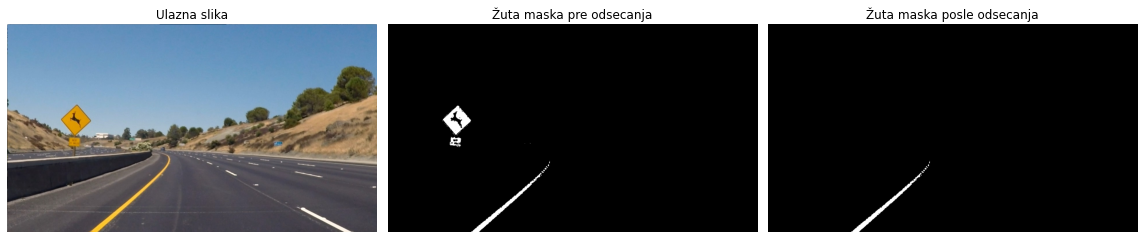

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 3 ,figsize=(16,15))
ax[0].imshow(image_2, vmin = 0, vmax = 255, cmap='jet'); ax[0].set_axis_off();
ax[0].set_title('Ulazna slika')

ax[1].imshow(yellow_mask, vmin=0, vmax=1, cmap='gray'); ax[1].set_axis_off();
ax[1].set_title('Žuta maska pre odsecanja')

ax[2].imshow(yellow_mask_crop, vmin=0, vmax=1, cmap='gray'); ax[2].set_axis_off();
ax[2].set_title('Žuta maska posle odsecanja')

plt.tight_layout()
plt.show()

**Zaključak:** Segmentacija je uspešno odrađena, kao i isecanje dela slike gde se mogu javiti smetnje na nekim frejmovima slike.

In [7]:
def sobel_gradient(image):
    """
    Input: image - grayscale image
    Outputs:
        - gradient magnitude
        - gradient angle (range [-pi/2,pi/2] rad, with respect to x axis)
    """
    Hx = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]]) #Sobelov operator
    Hy = np.transpose(Hx)
    
    # izracunavanje vertikalnog i horizontalnog gradijenta slike
    Gx = ndimage.correlate(image, Hx, mode='nearest')
    Gy = ndimage.correlate(image, Hy, mode='nearest')
    
    # magnituda gradijenta
    mag = np.sqrt(np.square(Gx) + np.square(Gy))
    angle2 = np.rad2deg(np.arctan2(Gy, Gx))
    return (mag, angle2)



def non_maximum_suppression(gradient_intensities, gradient_angles):
    """
    Inputs: 
        - gradient_intensities: matrix of gradient intensities of the input image
        - gradient_angles: matrix of gradient angles of the input image
    Outputs:
        - matrix of gradient intensities of the input image with better localization of pixels
    """
    # vazno da se ne radi inplace zakucavanje lokalnih ne-maksimuma na 0, pa max izdvajamo u novoj slici da se 
    #stara ne bi menjala za naredne iteracije
    
    [M,N] = gradient_intensities.shape
    suppressed_edges = np.zeros(gradient_intensities.shape)
    
    # Kvantizacija gradijenta na jedan od 4 pravaca -45,0,45,90
    gradient_angles[(gradient_angles > -67.5) & (gradient_angles < -22.5)] = -45
    gradient_angles[(gradient_angles >= -22.5) & (gradient_angles <=22.5)] = 0
    gradient_angles[(gradient_angles > 22.5) & (gradient_angles < 67.5)] = 45
    gradient_angles[(gradient_angles >= 67.5) & (gradient_angles <= 90)] = 90
    gradient_angles[(gradient_angles >= -90) & (gradient_angles <= -67.5)] = 90
    
    # znamo da nam je susedstvo po jedan piksel u svim pravcima, pa krecemo od (i,j) = (1,1)
    # Poredimo intenzitete piksela lokalnog susedstva koje je definisano kvantizovanim uglom gradijenta centralnog
    # piksela
    for i in range(1, M - 1):
        for j in range(1, N - 1):
            if (gradient_angles[i, j] == 45):
                max_neighbour = max(gradient_intensities[i - 1, j - 1], gradient_intensities[i + 1, j + 1])
            elif (gradient_angles[i, j] == -45):
                max_neighbour = max(gradient_intensities[i + 1, j - 1], gradient_intensities[i - 1, j + 1])
            elif (gradient_angles[i, j] == 90):
                max_neighbour = max(gradient_intensities[i, j - 1], gradient_intensities[i, j + 1])
            else: # gradijent == 0
                max_neighbour = max(gradient_intensities[i + 1, j], gradient_intensities[i - 1, j])
            
            if gradient_intensities[i, j] >= max_neighbour:
                suppressed_edges[i, j] = gradient_intensities[i, j]
    return suppressed_edges


def threshold(image_grad_mag, threshold_low, threshold_high):
    """
       Determination of strong and weak edge maps based on thresholds

       Inputs:
           image_gradient_mag: gradient magnitude
           threshold_low: absolute value of the lower threshold
           threshold_high: absolute value of the upper threshold

       Outputs:
           strong_and_weak_edges: an edge map containing both strong and weak edges
           weak_edges: an edge map containing only weak edges
           strong_edges: an edge map containing only strong edges
    """
    image_gradient_mag = image_grad_mag.copy()
    image_gradient_mag[image_gradient_mag >= threshold_high] = 1;
    image_gradient_mag[image_gradient_mag <= threshold_low] = 0;
    return image_gradient_mag


def hysteresis(mag_edges):
    """
    Including in the output edge map those weak edges that are connected to some strong edge
    
       Unputs - connected_edges: map of weak and strong edges
       Outputs: an edge map containing both strong and weak edges
    """
    connected_edges = mag_edges.copy()
    changed = 1
    while changed == 1:
        changed = 0

        connected_edges_padded = np.pad(connected_edges, ((1, 1), (1, 1)), 'edge')
        # i,j idu po neprosirenoj slici

        for i in range(1, connected_edges_padded.shape[0]-1):
            for j in range(1, connected_edges_padded.shape[1]-1):
                if ((connected_edges_padded[i, j] != 1) & (connected_edges_padded[i, j] != 0)):# ako je ivica slaba
                    if np.any(connected_edges_padded[i-1:i+1, j-1:j+1]): # ako u okolini ima bar jedan 'jak' piksel
                        connected_edges[i - 1, j - 1] = 1
                        changed = 1


    connected_edges[(connected_edges != 1) & (connected_edges != 0)] = 0; # ivice koju su ostale slabe stavi na 0
    return connected_edges


def canny_edge_detection_plot(img_in, sigma_param, threshold_low, threshold_high):
    """
       Inuts:
           -  img_in: map with strong and weak edges
           - sigma_param: standard deviation of Gaussian filter
           - threshold_low: absolute value of the lower threshold
           - threshold_high: absolute value of the upper threshold
           
       Output - connected_edges: map with strong and weak edges
    """
    # Za radijus Gausove funkcije usvojena je vrednost od 3*sigma_param.
    img_gauss = gaussian(img_in, sigma_param, mode='nearest', truncate=3)
    mag_g, angle_g = sobel_gradient(img_gauss)
    suppressed_gradients = non_maximum_suppression(mag_g, angle_g)
    image_gradient_mag = threshold(suppressed_gradients, threshold_low, threshold_high)
    canny_edges = hysteresis(image_gradient_mag)
    
    fig, ax = plt.subplots(nrows = 3, ncols=2, figsize=(16,18), dpi=80)
    ax[0,1].imshow(img_gauss, cmap = 'gray'); ax[0,1].set_axis_off();
    ax[0,1].set_title('Filtrirana slika Gausovim filtrom za \n$\sigma$ = ' + str(sigma_param)); 
    
    ax[1,0].imshow(mag_g, cmap = 'gray'); ax[1,0].set_axis_off();
    ax[1,0].set_title('Magnituda gradijenta');
    
    ax[1,1].imshow(suppressed_gradients, cmap = 'gray');ax[1,1].set_axis_off();
    ax[1,1].set_title('Mapa ivica sa potisnutim lokanlim ne-maksimumima');
    
    ax[2,0].imshow(image_gradient_mag, cmap = 'gray');ax[2,0].set_axis_off();
    ax[2,0].set_title('Mapa ivica posle poređenja s pragovima: niži = ' + str(threshold_low) + ', viši = ' \
                      + str(threshold_high));
    
    ax[2,1].imshow(canny_edges, cmap = 'gray');ax[2,1].set_axis_off();
    ax[2,1].set_title('Mapa ivica posle histerezisa');

    return (canny_edges,ax)
    

def canny_edge_detection(img_in, sigma_param, threshold_low, threshold_high):
    """
        Inuts:
           -  img_in: map with strong and weak edges
           - sigma_param: standard deviation of Gaussian filter
           - threshold_low: absolute value of the lower threshold
           - threshold_high: absolute value of the upper threshold
           
       Output - connected_edges: map with strong and weak edges
    """
    # Za radijus Gausove funkcije usvojena je vrednost od 3*sigma_param.
    img_gauss = gaussian(img_in, sigma_param, mode='nearest', truncate=3)
    mag_g, angle_g = sobel_gradient(img_gauss)
    suppressed_gradients = non_maximum_suppression(mag_g, angle_g)
    image_gradient_mag = threshold(suppressed_gradients, threshold_low, threshold_high)
    canny_edges = hysteresis(image_gradient_mag)
    return canny_edges
    
    

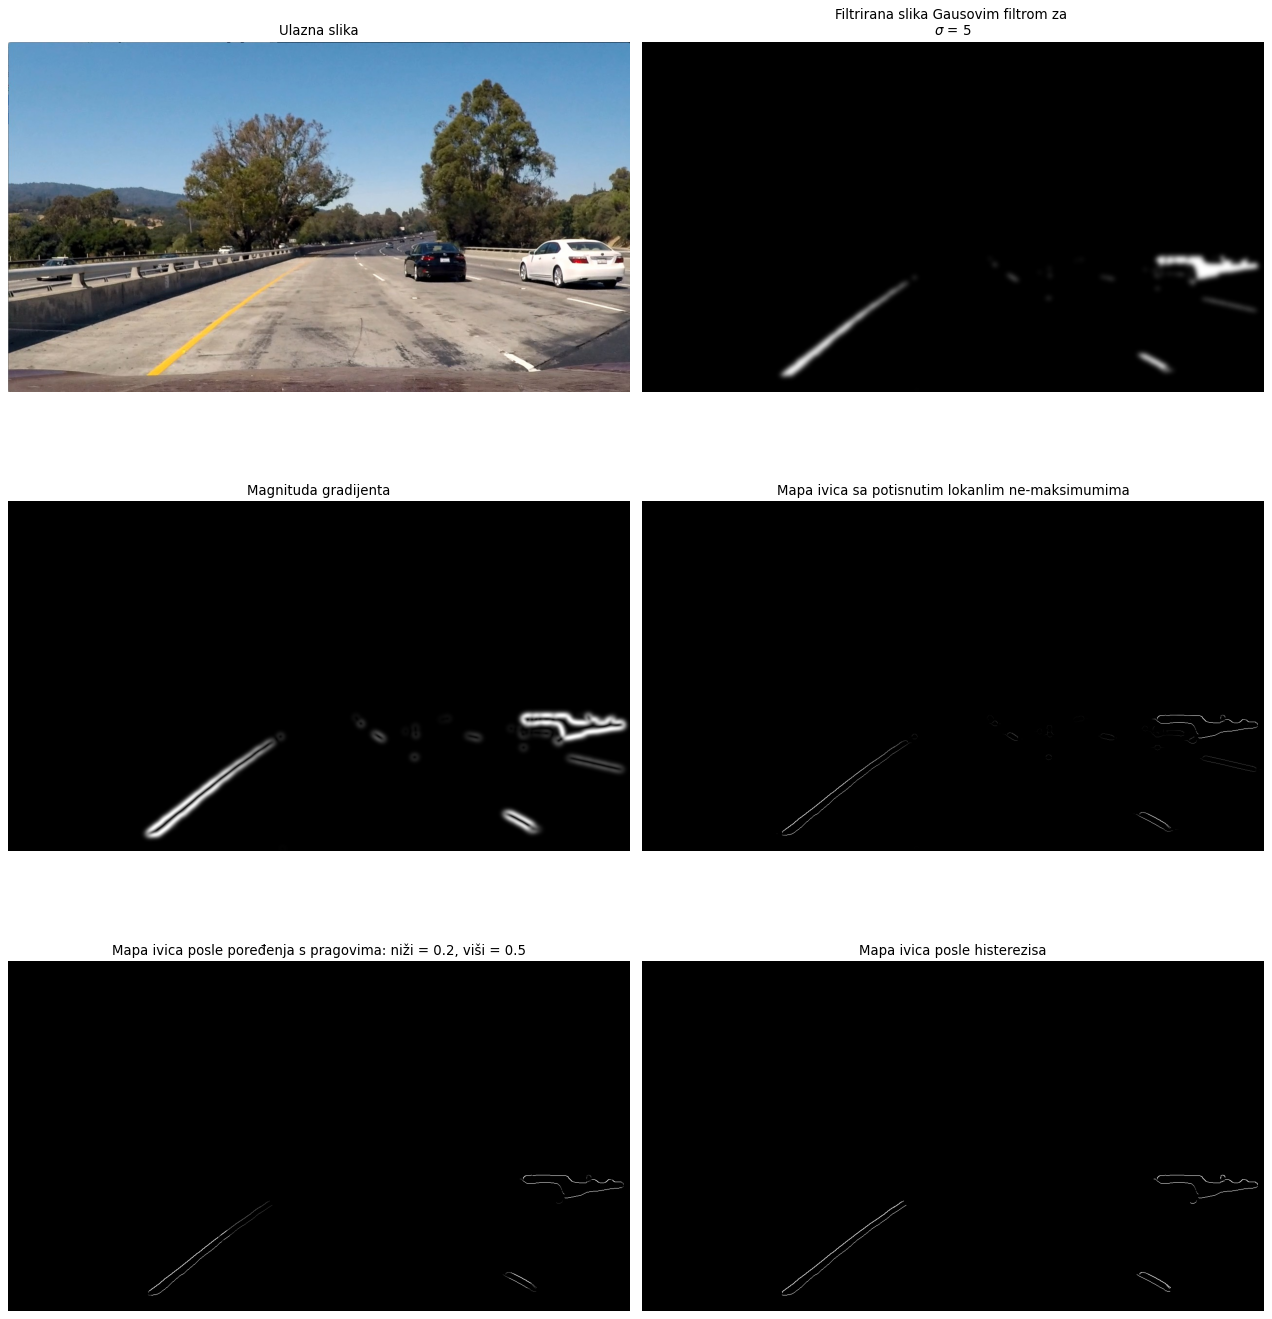

In [8]:
connected_edges,ax = canny_edge_detection_plot(segm_image_1, 5, 0.2, 0.5)
plt.axes(ax[0,0])
ax[0,0].imshow(image_1, vmin = 0, vmax = 255, cmap = 'jet');ax[0,0].set_axis_off();
ax[0,0].set_title('Ulazna slika');
plt.tight_layout()
plt.show()

**Zaključak:** Razlika u povezanosti ivica nije velika jer su detalji potisnuti, ali je primetno kako su jake ivice na izlazu Kanijevog detektora još jače u odnosu na izlaz iz prethodnog koraka algoritma. Takođe su potisnute slabe ivice koje su primetne na slici posle potiskivanja lokalnih ne-maksimuma, što je u ovom slučaju veoma dobro jer su te ivice predstavljale moguće smetnje pri detektovanju klovoznih traka.
Gausov filtar je potisnuo šum i pripremio teren za računanje magnitude i ugla gradijenta Sobelovim operatorom, koji je osetljiv na šum. Kao trade-off dobijamo lošu lokalizaciju ivica, što rešavamo potiskivanjem lokalnih ne-maksimuma. Posle ovog koraka imamo skup lokalnih ekstremuma koji potiču od šuma i od stvarnih ivičnih piksela. Poređenjem ovakve mapa ivica sa gornjim pragom obezbeđujemo sigurnu detekciju ivičnih piksela, a one magnitude gradijenta koji ostanu ispod donjeg praga sigurno potiču od šuma. Previsoki visok prag dovodi do proustenih detekcija jakih ivica. Prenizak donji prag dovodi do propuštanja šuma. Preostale piksele, koji su između ova dva praga klasifiujemo kao jake ukoliko se u njihovom lokalnom susedstu nalazi barem jedan piksel jake ivice, jer je verovanoća da i posmatrani piksel bude jak velika.

Na sledećoj slici su prikazani međukoraci za Kanijev detektor ivica u slučaju slike sa dosta više detalja i ivica.

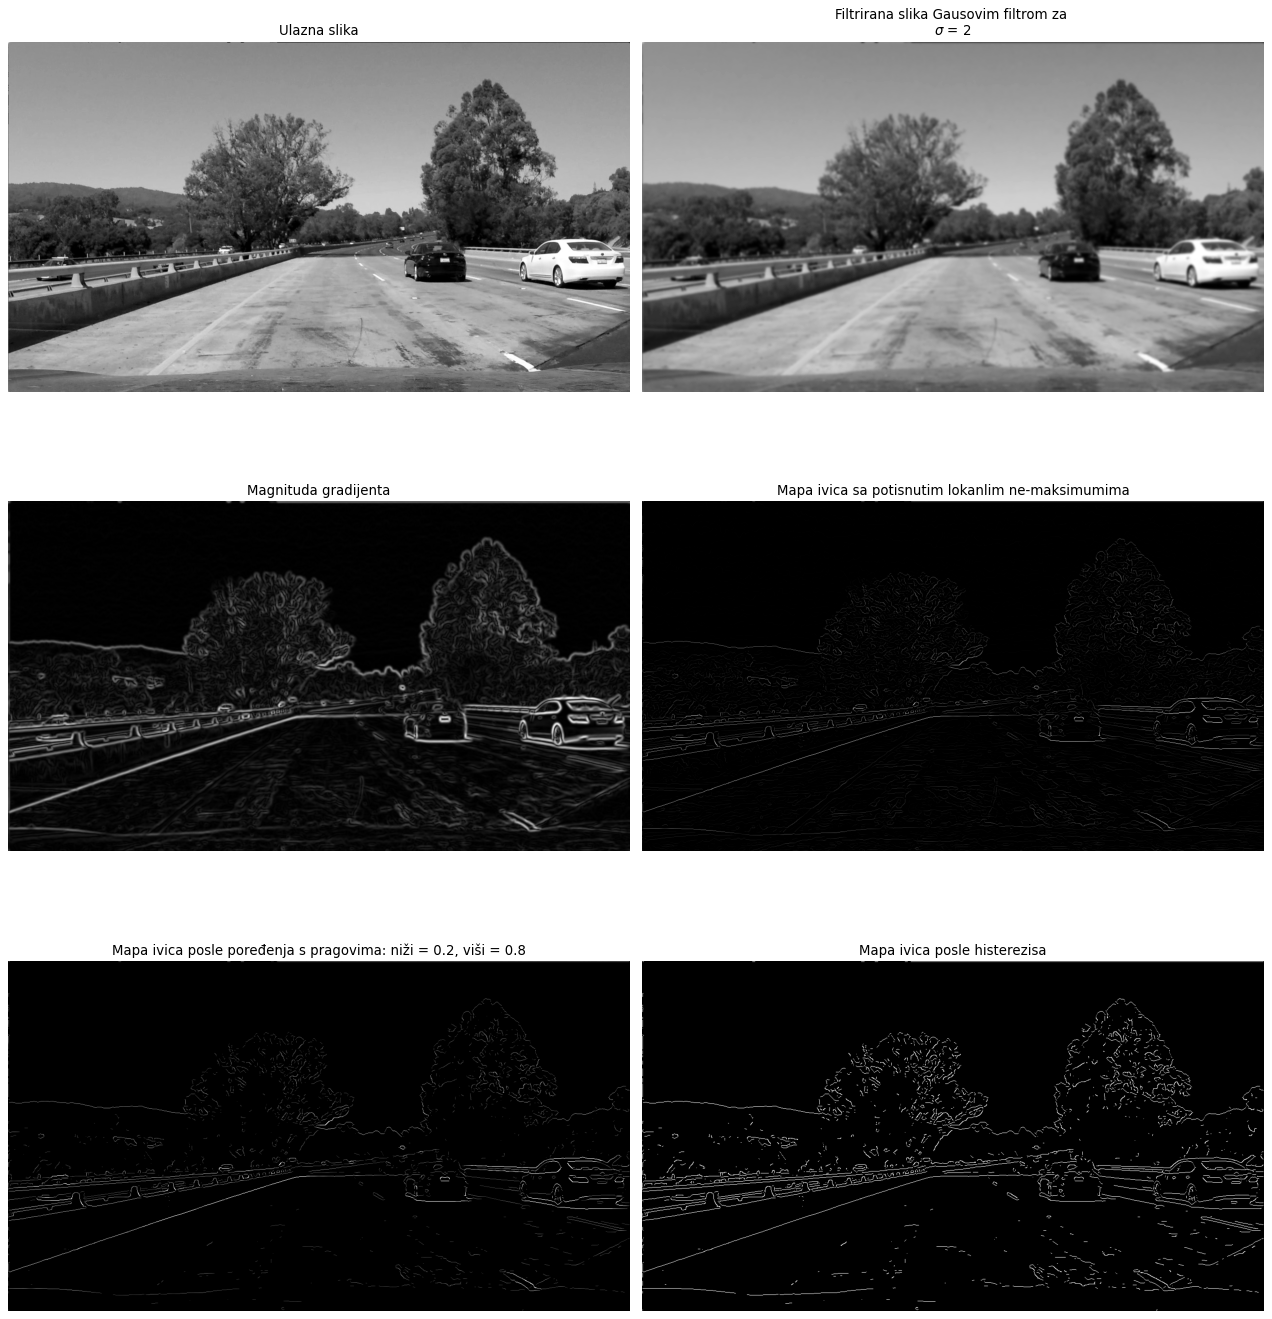

In [9]:
image_1_gray = rgb2gray(image_1)
connected_edges,ax = canny_edge_detection_plot(image_1_gray, 2, 0.2, 0.8)
plt.axes(ax[0,0])
ax[0,0].imshow(image_1_gray, vmin = 0, vmax = 1, cmap = 'gray');ax[0,0].set_axis_off();
ax[0,0].set_title('Ulazna slika');
plt.tight_layout()
plt.show()

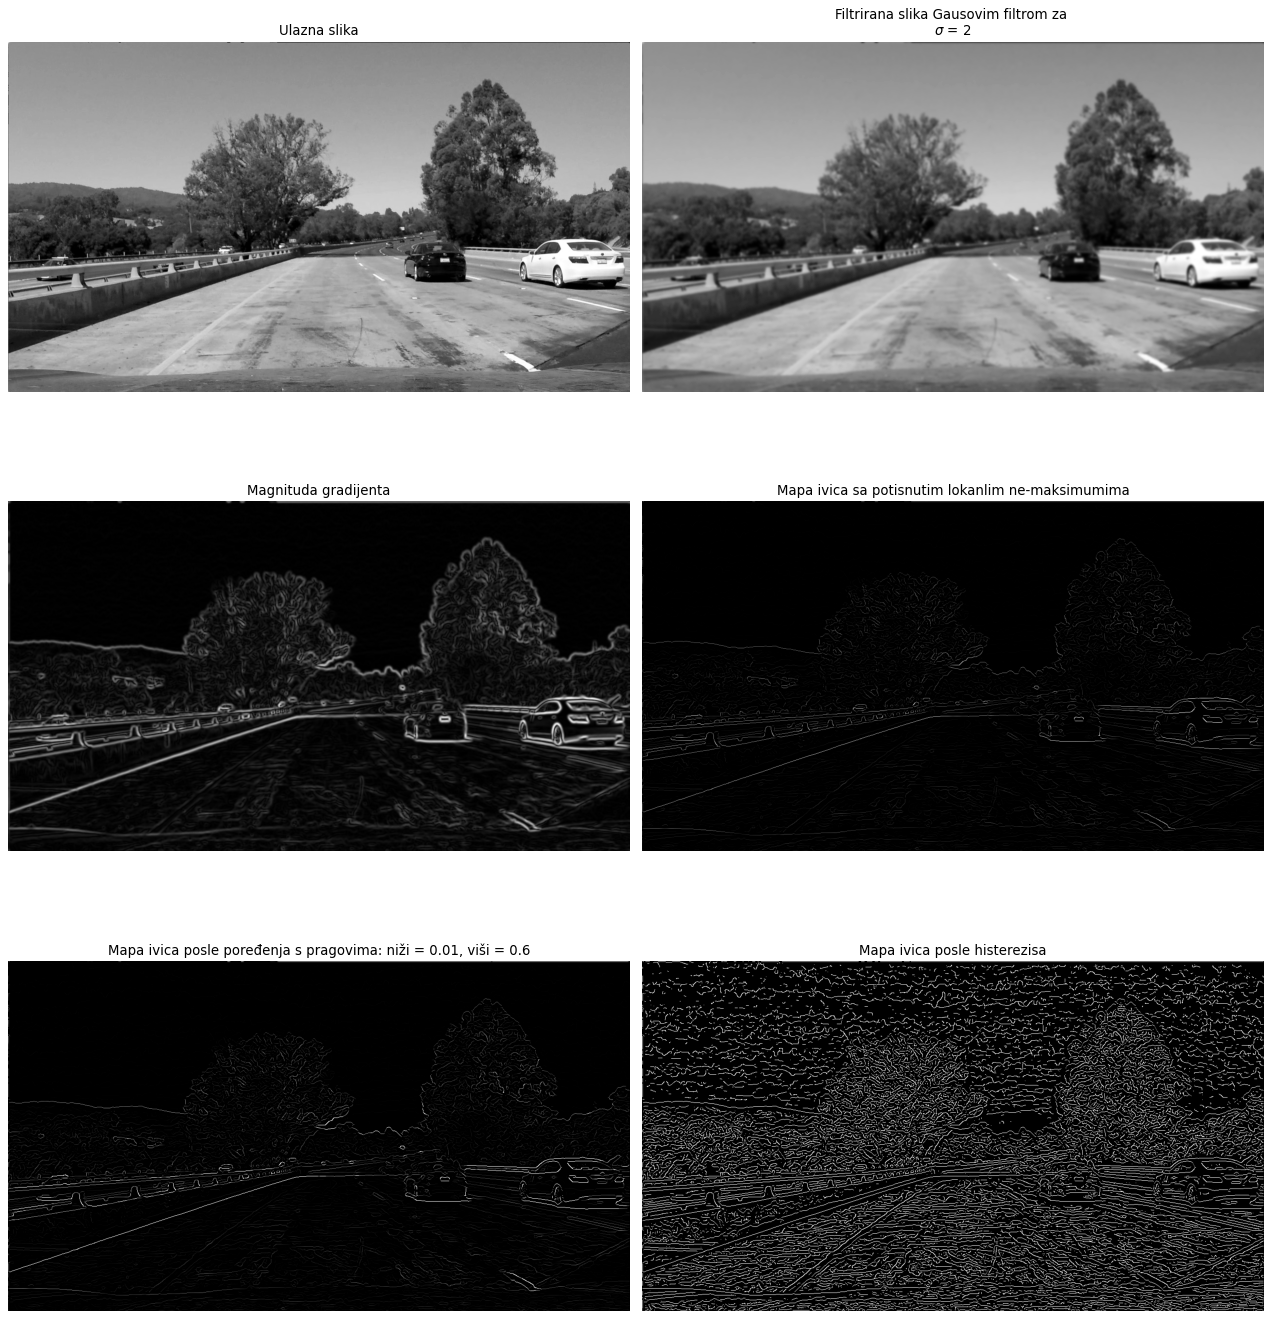

In [10]:
connected_edges,ax = canny_edge_detection_plot(image_1_gray, 2, 0.01, 0.6)
plt.axes(ax[0,0])
ax[0,0].imshow(image_1_gray, vmin = 0, vmax = 1, cmap = 'gray');ax[0,0].set_axis_off();
ax[0,0].set_title('Ulazna slika');
plt.tight_layout()
plt.show()

Gore prikazan primer je sa loše uzetim parametrima, gde se pojavio šum zbog preniskog donjeg praga histerezisa. Dakle, treba povećati donji prah, eventualno malo i gornji, i možda povećati Gausov filar, pa balansiranjem parametara doći do zadovoljavajućih rezultata.

In [11]:
def get_line_segments(egdes_map, line, min_size, max_gaps, tolerancy):
    """
    Inputs:
        - egdes_map: map of image edges
        - line: list of parameters of a line in Hough space - [rho i theta]
        - min_size: minimum segment length (in pixels) to be detected, all
                    lines smaller than this size should be ignored. The reverse argument of this
                    functions are all longer whose length is greater than this parameter.
        - max_gaps – maximum break sizes (in pixels) that can be ignored when detecting lengths
        - tolerancy – the radius of the environment within which the edge pixels are searched
    Output: coordinates of all detected lengths located on the line determined by the parameters rho i theta
    """
    rho = line[0]
    theta = line[1]

    dots_tol = [] # ovde cuvamo tačke ivica koje ne odstupaju vise od zadate tolerancije od prave odredjene sa rho i theta
    y_coord, x_coord = np.where(egdes_map > 0)# koordinate piksela koji sadrže ivice
    for i in range(0,len(x_coord)):
        # levog ugla - levo najblize kolima
        if (abs(x_coord[i]*np.cos(theta)+y_coord[i]*np.sin(theta) - rho) < tolerancy):
            dots_tol.append([x_coord[i],y_coord[i]])
    
    if (len(dots_tol) < 2): 
        return []
    else:
        # provera da li izdvojene tacke zadovoljavaju potrebne kriterijume
        first = [0,0]
        last = [0,0]
        lines = []
        dots_tol = np.array(dots_tol)
        first = dots_tol[0] # prva je dole levo najblize kolima [x,y]
        for i in range(1,len(dots_tol)):
            # provera da li je gap[pix] preveliki
            if(np.linalg.norm(dots_tol[i] - dots_tol[i-1]) > max_gaps):
                # ako je praznina izmedju tacaka na istom pravcu prevelika, zaustavljamo se na prethodnoj koja je
                # potencijalno duz na zadatom pravcu prave
                if (np.linalg.norm(first - dots_tol[i-1]) > min_size): # ako je ta duz nije prekratka zapamti 
                    # [[x_poc,y_poc],[x_krajnja, y_krajnja]]- jedna linija jedna lista
                    lines.append([first,dots_tol[i-1]])
                first = dots_tol[i] #apdejtuj i-tu tacku kao nov pocetak duzi 
                continue
        if not lines: # ako su svi prekidi na zadatom pravcu ispod granica tolerancije za max_gaps i min_size
            # onda je poslednja tacka - ona najudaljenija od auta druga tacka nase duzi
            lines.append([first,dots_tol[len(dots_tol)-1]])
       
        return lines # oblik je [ [[x_poc,y_poc],[x_kraj, y_kraj]] , duz2...]

In [12]:
# Inicijalni globalnih parametara pravih, promenice se pri prvoj iteraciji, i od tada se ažuriraju u svakoj iteraciji 
# kako bi ta informacija bila iskorišćena u slučaju da se ne može detektovati linija na putu
rho_r_prev = 10000
theta_r_prev = 10000
lines_r_prev = []
lines_l_prev = []

def lane_detection(frame):
    """
       Input:
           -  frame: input image
       Output -the coordinates of the starting and ending points of the lines that detect the left and right lanes
    """
    
    global rho_r_prev
    global theta_r_prev
    global lines_r_prev
    global lines_l_prev
    
    # segmentacija frejma
    segmented_frame,_,_,_ = segment_lanes(frame)
    # određivanje ivica u frejmu
    image_edges = canny_edge_detection(segmented_frame,5,0.03,0.2)
    
    rho_r = 0
    theta_r = 0
    theta_r_vector = [] 
    rho_r_vector = []
    rho_l = 0
    theta_l = 0
    num = 0
    found_r = 0
    
    # DESNA TRAKA:
    
    if (theta_r_prev == 10000):
        # opseg uglova gradijenta koji se očekuje za desnu traku
        # Parametri su fino podešeni tako da se izbegnu slučajevi kada se detektuju neke smetnje poput linije na
        # belim kolima koje se mogu interpretirati kao isprekidana bela desna traka na putu
        theta_range = np.linspace(-np.pi/2.9,-np.pi/3.7,360,endpoint = True)
        [out,angles,distances] = hough_line(image_edges,theta = theta_range)
        [intensity,peak_angles,peak_distances] = hough_line_peaks(out,angles,distances,min_distance=5,min_angle=1,threshold=None,num_peaks=5)

        
        for angle,dist in zip(peak_angles,peak_distances):
            # Na ovaj način razdvajamo desnu od leve trake i kada se detektju potezi koji u ovom opsegu usrednjavamo
            # ih jer traka ima više linija ivica sa parametrima koji se razlikuju, pa ih treba usrednjiti za 
            # verodostojniju procenu. Takođe treba pamtiti parametre pravih u vektor kako bi se kasnije odredila medijana.
            # Ona je robusna kada imamo dosta autlajera.
            if dist<200 and dist > - 350:
                num+=1
                theta_r_vector.append(angle)
                rho_r_vector.append(dist)
        if num > 0:
            theta_r = np.median(theta_r_vector)
            rho_r = np.median(rho_r_vector)
            found_r = 1
            # Promađene parametre prave u Hafovom prostoru prosleđujemo fukciji koja će odrediti početne i krajnje tačke
            # koje možemo detektovati na desnoj traci
            lines_r = get_line_segments(image_edges,[rho_r,theta_r],5,450,10)
        else:
            # U slučaju da je slaba desna traka treba povećati pikova tj pravih koje želimo da detektujemo
            lines_r = []
            rho_r_vector.clear()
            theta_r_vector.clear()
            # željeni broj pravih stavljamo sa 5 na 100
            [intensity,peak_angles,peak_distances] = hough_line_peaks(out,angles,distances,min_distance=5,min_angle=1,threshold=None,num_peaks=100) 
            # ponavlja se ista procedura koja je prethodno opisana 
            for angle,dist in zip(peak_angles,peak_distances):
                if dist<200 and dist > - 350:
                    num+=1
                    theta_r_vector.append(angle)
                    rho_r_vector.append(dist)

            if num > 0:
                theta_r = np.median(theta_r_vector)
                rho_r = np.median(rho_r_vector)
                found_r = 1  
                #print(usao)
                lines_r = get_line_segments(image_edges,[rho_r,theta_r],5,450,10) 


            if not lines_r:
                # Ukoliko se desi da se ne mogu detektovati duži na desnoj traci ponavlja se procedura
                # sa restriktivnijim uslovima
                rho_r_vector.clear()
                theta_r_vector.clear()
                # ovo se desava kada je auto u cosku pa se od njega javljaju paralelne linije
                # one ugl imaju pozitivnu distancu
                for angle,dist in zip(peak_angles,peak_distances):
                    if dist<0 and dist>-350:
                        num+=1
                        theta_r_vector.append(angle)
                        rho_r_vector.append(dist)

                if num > 0:
                    theta_r = np.median(theta_r_vector)
                    rho_r = np.median(rho_r_vector)
                    found_r = 1  
                    #print('treci')
                    lines_r = get_line_segments(image_edges,[rho_r,theta_r],5,450,10) 


    else:
        # Sada je dostupan početni frejm i ograničava se ugao teta jer ne očeujemo velike oscilacije u uglu,
        # na taj način smanjujemo varovatnoću da se uhvati neka linija koja ne pripada ivici desne trake.
        # Ostatak procedure je isti kao u slučaju početnog frejma
        theta_low = max(theta_r_prev*0.99,-np.pi/2.9)
        theta_high = min(theta_r_prev*1.01,-np.pi/3.7)
        theta_range = np.linspace(theta_low,theta_high,360,endpoint = True)

        [out,angles,distances] = hough_line(image_edges,theta = theta_range)
        [intensity,peak_angles,peak_distances] = hough_line_peaks(out,angles,distances,min_distance=5,min_angle=1,threshold=None,num_peaks=5)

        
        for angle,dist in zip(peak_angles,peak_distances):
            if (dist>rho_r_prev-100) and (dist < rho_r_prev+100) and dist<0:
                num+=1
                theta_r_vector.append(angle)
                rho_r_vector.append(dist)
        if num > 0:
            theta_r = np.median(theta_r_vector)
            rho_r = np.median(rho_r_vector)
            found_r = 1
            lines_r = get_line_segments(image_edges,[rho_r,theta_r],5,450,10) 
        
        else:
            lines_r = []
            rho_r_vector.clear()
            theta_r_vector.clear()
            # U slučaju da je slaba desna traka treba povećati pikova tj pravih koje želimo da detektujemo
            # pocećavamo na 200
            [intensity,peak_angles,peak_distances] = hough_line_peaks(out,angles,distances,min_distance=5,min_angle=1,threshold=None,num_peaks=200) 
            for angle,dist in zip(peak_angles,peak_distances):
                # uslovi koji ofraničavaju mešanje sa levom trakom
                if (dist>rho_r_prev-90) and (dist < rho_r_prev+90) and dist<0:
                    num+=1
                    theta_r_vector.append(angle)
                    rho_r_vector.append(dist)

            if num > 0:
                theta_r = np.median(theta_r_vector)
                rho_r = np.median(rho_r_vector)
                found_r = 1  
                lines_r = get_line_segments(image_edges,[rho_r,theta_r],5,450,10) 


            # Ako nisu nađene duži desne trake pokušamo da ih detektujemo sa manje agresivnom obradom frejma:
            # Manja standardna devijacija Gausovog filtra, jer je možda bio prejak pa je razmrljao ono malo što je 
            # ostalo od desne trake.
            if not lines_r:
                image_edges = canny_edge_detection(segmented_frame, 1, 0.001, 0.2)

                theta_r = theta_r_prev
                rho_r = rho_r_prev
                found_r = 1  
                #print('treci')
                lines_r = get_line_segments(image_edges,[rho_r,theta_r],5,450,10) 
                # Ako duži desne trake opet nisu pronađene onda se uzimaju duži prethodnog frejma jer je odstupanje 
                # zanemarljivo malo.
                if not lines_r:
                    duzi_r = lines_r_prev
                # ili ako je tetektovana susedna tačka koja označava kraj duži - dobijemo duž paralelnu x osi
                # takođe će se uzeti duži iz prethodnog frejma.
                elif (lines_r[0][0][1]-lines_r[len(lines_r)-1][0][1]) == 0:
                    lines_r = lines_r_prev
        
    # ažuriranje uglova i potega za naradnu iteraciju
    theta_r_prev = theta_r
    rho_r_prev = rho_r
    """
    Plot da vidimo koje su sve linije detektovane za desnu traku.
    fix, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].imshow(img_edges, cmap=plt.cm.gray)
    ax[0].set_title('desna')
    origin = np.array((0, img_edges.shape[1]))
    for _, angle, dist in zip(intensity, peak_angles, peak_distances):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        ax[0].plot(origin, (y0, y1), '-r')
    
    y0, y1 = (ro_r - origin * np.cos(theta_r)) / np.sin(theta_r)
    ax[1].plot(origin, (y0, y1), '-g')
    """
 
    # LEVA TRAKA:
    num = 0
    found_l = 0
    theta_range = np.linspace(0,np.pi/2.15,360,endpoint = False)
    [out,angles,distances] = hough_line(image_edges,theta = theta_range)
    [intensity,peak_angles,peak_distances] = hough_line_peaks(out,angles,distances,min_distance=30,min_angle=5,threshold=None,num_peaks=10)
    
    for angle,dist in zip(peak_angles,peak_distances):
        if dist>650:
            num+=1
            theta_l+=angle
            rho_l+=dist
    if num > 0:
        theta_l = theta_l/num
        rho_l = rho_l/num
        found_l = 1
        lines_l = get_line_segments(image_edges,[rho_l,theta_l],30,150,10) 
    else:
        lines_l = []
    if not lines_l:
        lines_l = lines_l_prev
    
    
    """
    ax[1].imshow(img_edges, cmap=plt.cm.gray)
    ax[1].set_title('leva')
    origin = np.array((0, img_edges.shape[1]))
    for _, angle, dist in zip(intensity, peak_angles, peak_distances):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        ax[0].plot(origin, (y0, y1), '-r')
    
    y0, y1 = (ro_l - origin * np.cos(theta_l)) / np.sin(theta_l)
    ax[1].plot(origin, (y0, y1), '-g')
    """
    
    
    
    lines_r_prev = lines_r
    lines_l_prev = lines_l

    return ([lines_r[0],lines_r[len(lines_r)-1]],[lines_l[0],lines_l[len(lines_l)-1]])

## Plotting detection results

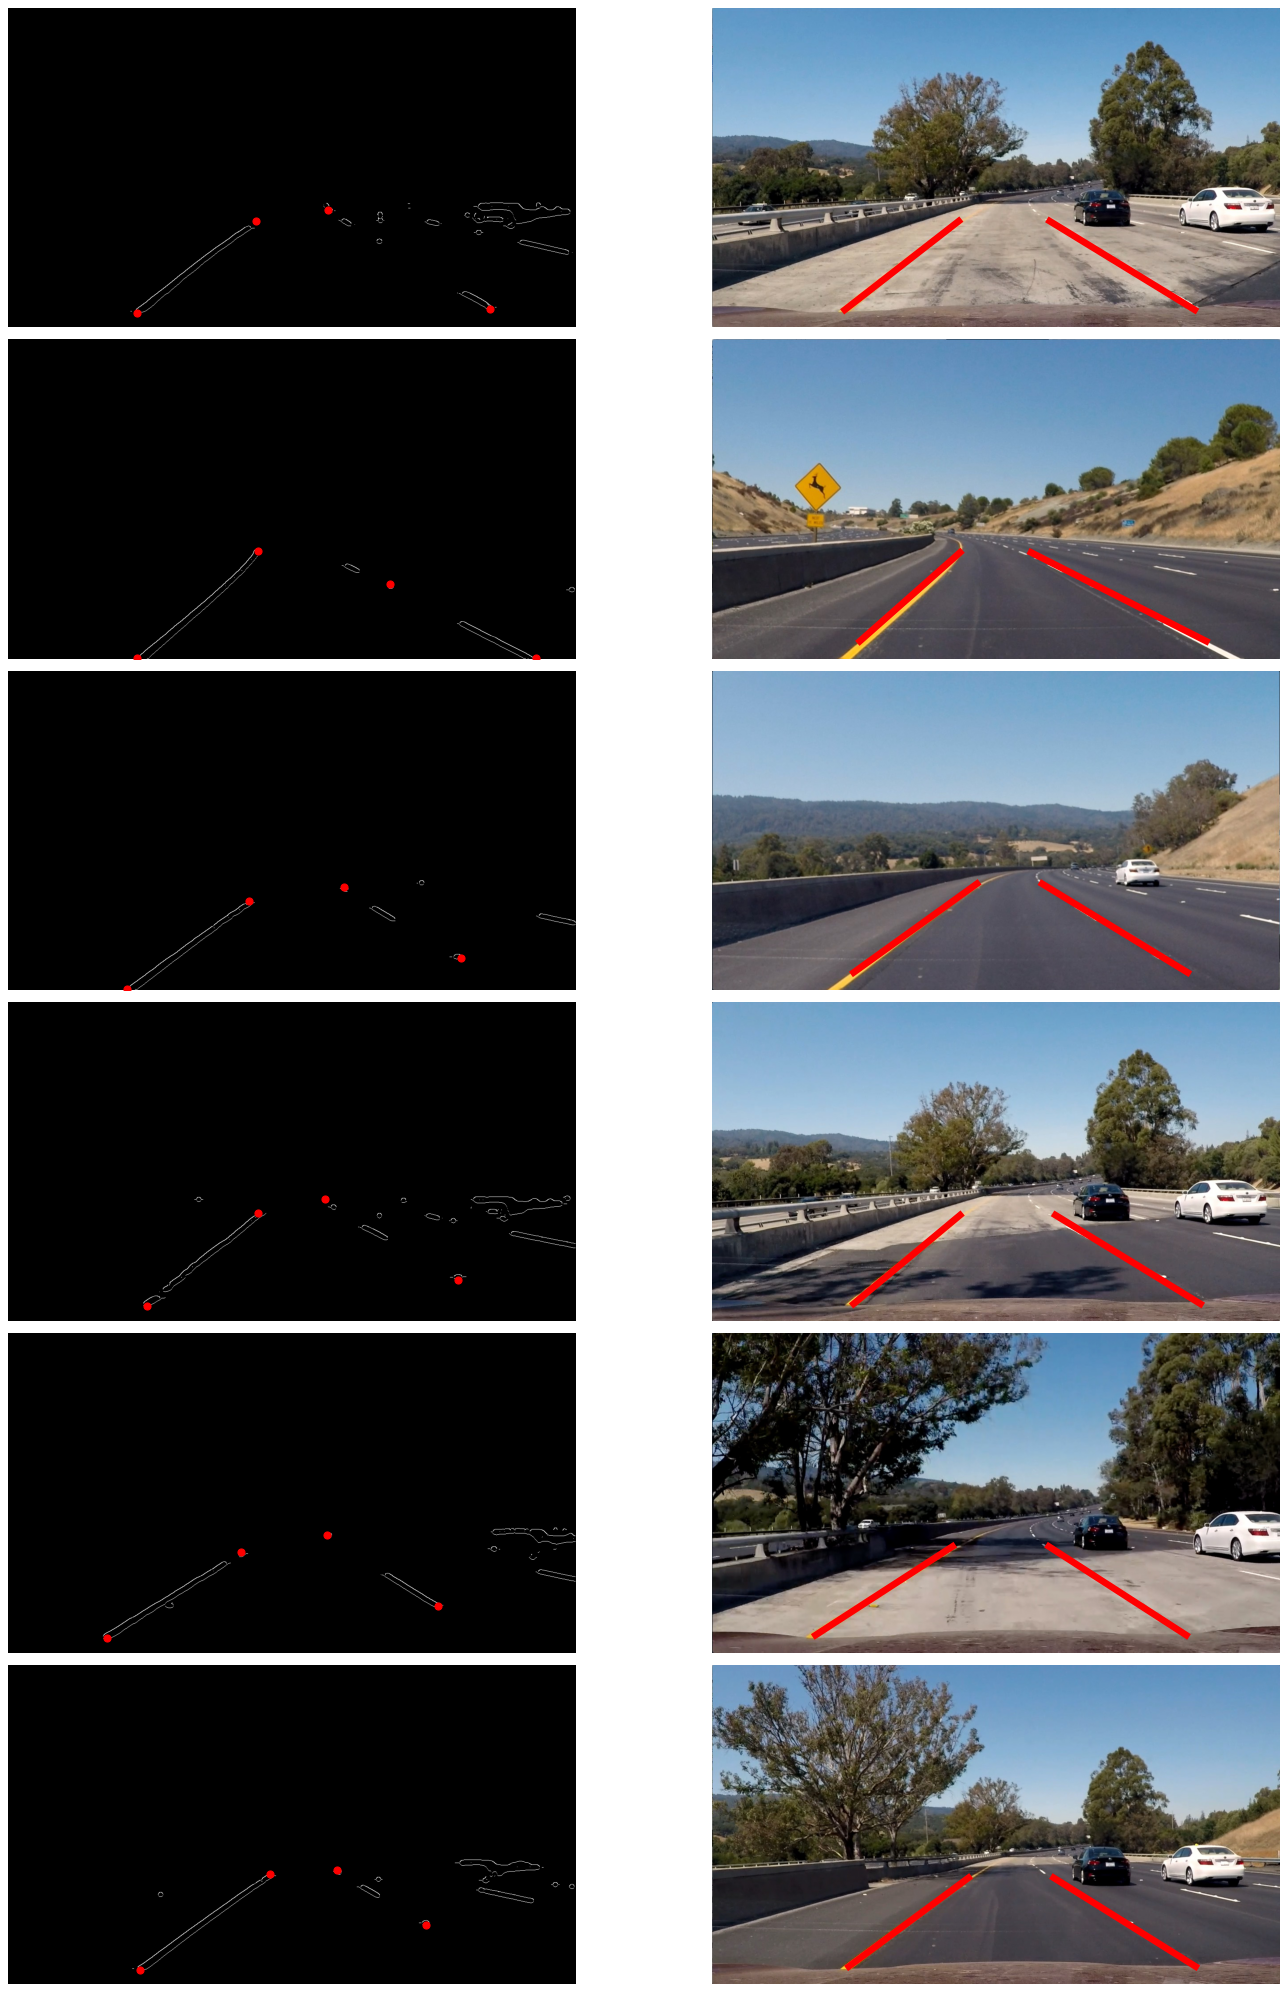

In [20]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize=(20,25), dpi=80)

for i in range(6):
    
    name = 'test' + str(i+1)
    image = imageio.imread(".\\sekvence\\" + name + '.jpg')
    segm_image,_,_,_ = segment_lanes(image)
    canny_image = canny_edge_detection(segm_image,5,0.03,0.2)
    dots_r, dots_l = lane_detection(image)
    dots_r_vector = np.array(dots_r[0])
    dots_l_vector = np.array(dots_l[0])
    r_y1 = dots_r_vector[0,1]
    r_x1 = dots_r_vector[0,0]
    r_y2 = dots_r_vector[1,1]
    r_x2 = dots_r_vector[1,0]

    l_y1 = dots_l_vector[0,1]
    l_x1 = dots_l_vector[0,0]
    l_y2 = dots_l_vector[1,1]
    l_x2 = dots_l_vector[1,0]
        
    axes[i,0].imshow(canny_image, vmin = 0, vmax = 1, cmap = 'gray'); axes[i,0].set_axis_off();
    axes[i,0].scatter(x=[r_x1,r_x2,l_x1,l_x2],y=[r_y1,r_y2,l_y1,l_y2], c='r', s=40)
 
    y_down = 680
    y_up = 480
    k_right = (r_x2 - r_x1)/(r_y2 - r_y1)
    n_right = r_x2 - k_right * r_y2
    x_down_right = int(y_down*k_right + n_right)
    x_up_right = int(y_up*k_right + n_right)
    
    k_left = (l_x2 - l_x1)/(l_y2 - l_y1)
    n_left = l_x2 - k_left * l_y2
    x_down_left = int(y_down*k_left + n_left)
    x_up_left = int(y_up*k_left + n_left)

    axes[i,1].imshow(image, vmin=0, vmax=255, cmap='jet'); axes[i,1].set_axis_off();
    axes[i,1].add_line(plt.Line2D(xdata = (x_down_right, x_up_right), ydata = (y_down,y_up), linewidth = 6, color = 'r'))
    axes[i,1].add_line(plt.Line2D(xdata = (x_down_left, x_up_left), ydata = (y_down,y_up), linewidth = 6, color = 'r'))
    
plt.tight_layout()
plt.show()

**Zaljučak**: Na prikazanim test primerima sa leve strane su prikazane ivice koje su dobijene Kanijevim detektorom, na osnovu kojih su pronađene i početne i krajnje tačke kolovoznih traka. Sa desne strane su frejmovi sa ucrtanim lociranim trakama.

# Video processing

In [14]:
"""
in_video = skvideo.io.vread("sekvence/video_road.mp4")
out_video = in_video.copy()
frames_range = in_video.shape[0]
for i in range(frames_range):
    dots_r, dots_l = lane_detection(out_video[i])
    dots_rrr = np.array(dots_r[0])
    dots_lll = np.array(dots_l[0])
    r_y1 = dots_rrr[0,1]
    r_x1 = dots_rrr[0,0]
    r_y2 = dots_rrr[1,1]
    r_x2 = dots_rrr[1,0]

    l_y1 = dots_lll[0,1]
    l_x1 = dots_lll[0,0]
    l_y2 = dots_lll[1,1]
    l_x2 = dots_lll[1,0]
    
    # Usvajaju se visine za iscrtavanje linija i određuju se nagib prave i druge dve koordinate do kojih će ići duž
    # na videu
    y_down = 675
    y_up = 485
    k_right = (r_x2 - r_x1)/(r_y2 - r_y1)
    n_right = r_x2 - k_right * r_y2
    x_down_right = int(y_down*k_right + n_right)
    x_up_right = int(y_up*k_right + n_right)
    
    k_left = (l_x2 - l_x1)/(l_y2 - l_y1)
    n_left = l_x2 - k_left * l_y2
    x_down_left = int(y_down*k_left + n_left)
    x_up_left = int(y_up*k_left + n_left)
    
    cv2.line(out_video[i],(x_down_right, y_down),(x_up_right, y_up),(0,255,0),11) # Draw a Red Line(BGR in OpenCV)
    cv2.line(out_video[i],(x_down_left, y_down),(x_up_left, y_up),(0,255,0),11) # Draw a Red Line(BGR in OpenCV)c

    imageio.mimwrite(os.getcwd() + '\\sekvence\\out_vid_vera.mp4', out_video, fps=25.0)
"""

'\nin_video = skvideo.io.vread("sekvence/video_road.mp4")\nout_video = in_video.copy()\nframes_range = in_video.shape[0]\nfor i in range(frames_range):\n    dots_r, dots_l = lane_detection(out_video[i])\n    dots_rrr = np.array(dots_r[0])\n    dots_lll = np.array(dots_l[0])\n    r_y1 = dots_rrr[0,1]\n    r_x1 = dots_rrr[0,0]\n    r_y2 = dots_rrr[1,1]\n    r_x2 = dots_rrr[1,0]\n\n    l_y1 = dots_lll[0,1]\n    l_x1 = dots_lll[0,0]\n    l_y2 = dots_lll[1,1]\n    l_x2 = dots_lll[1,0]\n    \n    # Usvajaju se visine za iscrtavanje linija i određuju se nagib prave i druge dve koordinate do kojih će ići duž\n    # na videu\n    y_down = 675\n    y_up = 485\n    k_right = (r_x2 - r_x1)/(r_y2 - r_y1)\n    n_right = r_x2 - k_right * r_y2\n    x_down_right = int(y_down*k_right + n_right)\n    x_up_right = int(y_up*k_right + n_right)\n    \n    k_left = (l_x2 - l_x1)/(l_y2 - l_y1)\n    n_left = l_x2 - k_left * l_y2\n    x_down_left = int(y_down*k_left + n_left)\n    x_up_left = int(y_up*k_left + n